In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots

In [2]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
input_dir = "./InputData/"
output_dir = "./OutputData/"

## Data prep

In [50]:
# Load data, convert "time" to datetime format, add deficit column
df = pd.read_csv(output_dir + "full_data.csv")
df["time"] = pd.to_datetime(df["time"], format = "%d:%m:%Y:%H:%M")
df["deficit"] = df["consumption_MWh"] - df["total_generation_MWh"]

In [51]:
df

,time,consumption_MWh,total_generation_MWh,natural_gas,hydro_dam,lignite,hydro_river,coal_imported,wind,solar,...,hard_coal,biomass,naphtha,LNG,international,waste_heat,TRY/MWh,USD/MWh,EUR/MWh,deficit
0,2021-01-01 00:00:00,29489.46,29488.11,7083.97,1551.39,5256.89,686.07,7673.92,4836.19,0.0,...,603.87,577.37,0.0,0.0,-364.20,92.84,263.99,35.96,29.31,1.35
1,2021-01-01 01:00:00,28067.11,28065.76,6072.81,1387.63,5121.95,703.90,7530.56,4826.45,0.0,...,599.09,575.69,0.0,0.0,-346.00,92.63,236.99,32.29,26.31,1.35
2,2021-01-01 02:00:00,26527.08,26527.08,4878.19,1507.96,5110.55,667.26,6979.91,4750.11,0.0,...,603.49,581.60,0.0,0.0,-142.00,89.96,216.70,29.52,24.06,0.00
3,2021-01-01 03:00:00,25327.19,25327.19,4394.61,1652.86,5029.12,651.91,6536.85,4432.18,0.0,...,603.81,579.64,0.0,0.0,-145.00,90.96,218.07,29.71,24.21,0.00
4,2021-01-01 04:00:00,24719.72,24719.72,4191.38,1615.38,5012.93,670.94,6266.92,4321.98,0.0,...,602.66,583.37,0.0,0.0,-137.00,91.99,208.99,28.47,23.20,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2023-12-31 19:00:00,35090.93,34753.40,5567.82,8719.86,5311.18,2287.36,9100.92,359.70,0.0,...,613.05,997.70,0.0,0.0,270.20,82.49,2499.67,84.91,76.74,337.53
26276,2023-12-31 20:00:00,33310.94,31441.31,4792.96,7881.64,4908.48,2083.33,7613.93,459.87,0.0,...,612.95,983.26,0.0,0.0,539.84,85.01,2472.34,83.98,75.90,1869.63
26277,2023-12-31 21:00:00,32083.96,30368.98,4000.94,7513.96,4911.94,1966.32,7656.56,552.62,0.0,...,607.59,977.02,0.0,0.0,629.91,84.63,2472.33,83.98,75.90,1714.98
26278,2023-12-31 22:00:00,30469.49,30386.41,2903.52,8119.63,4615.93,1837.75,8390.47,720.11,0.0,...,608.31,987.47,0.0,0.0,627.77,83.35,1800.00,61.15,55.26,83.08


In [52]:
# Aggregate by day
df_daily = df.copy().set_index("time")
agg_funcs = ("sum " * 18).split(" ")[0:-1]
agg_funcs = agg_funcs + ["mean", "mean", "mean", "sum"]
agg_cols = dict(zip(df_daily.columns.values, agg_funcs))
df_daily = df_daily.groupby(df_daily.index.date).aggregate(agg_cols).reset_index(names = "time")

In [53]:
df_daily

,time,consumption_MWh,total_generation_MWh,natural_gas,hydro_dam,lignite,hydro_river,coal_imported,wind,solar,...,hard_coal,biomass,naphtha,LNG,international,waste_heat,TRY/MWh,USD/MWh,EUR/MWh,deficit
0,2021-01-01,695973.69,672846.34,154446.31,70349.58,118600.53,21795.46,172582.66,70279.77,1569.11,...,14654.18,13925.81,0.0,0.0,-3325.80,2176.96,255.943750,34.866667,28.414167,23127.35
1,2021-01-02,726646.43,703147.49,212244.27,95287.29,115779.50,16991.52,178817.66,21775.92,1477.74,...,14693.32,13801.49,0.0,0.0,-3586.72,2174.70,292.609583,39.438333,32.097917,23498.94
2,2021-01-03,720560.60,697739.86,215219.71,67270.50,113147.94,15888.61,187345.46,32154.26,1569.91,...,15018.06,13768.97,0.0,0.0,-1447.73,2209.88,289.038750,38.957500,31.706250,22820.74
3,2021-01-04,853158.67,827933.70,264835.26,98842.41,117776.40,18721.05,190899.53,72011.91,1570.12,...,13133.65,13797.58,0.0,0.0,-1324.03,2334.97,295.701250,39.855417,32.436667,25224.97
4,2021-01-05,881358.19,862057.66,263859.28,95011.17,118798.28,19070.18,200454.16,104335.83,1220.77,...,10799.67,13560.69,0.0,0.0,-3020.87,2315.38,288.071667,38.825833,31.599583,19300.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,909315.54,856208.37,142398.25,190742.68,115704.89,52189.57,183787.70,68434.22,9165.28,...,14266.03,23940.91,0.0,0.0,15985.42,1786.96,2114.216667,72.378750,65.706250,53107.17
1091,2023-12-28,905605.21,853261.07,135465.07,192632.99,127101.97,49956.02,197843.77,46635.31,8861.83,...,14386.98,23979.82,0.0,0.0,16837.98,1946.87,2123.542083,72.562917,65.861250,52344.14
1092,2023-12-29,892609.49,832640.42,130462.50,183107.01,127252.58,47398.82,194948.13,42067.22,7883.39,...,14749.89,24333.89,0.0,0.0,20388.08,1996.91,2201.463750,75.037917,67.908333,59969.07
1093,2023-12-30,834855.23,781688.92,90015.98,173765.66,120931.96,45002.51,196260.36,49183.75,9110.93,...,14664.43,24033.67,0.0,0.0,19247.38,2137.30,2003.797500,68.162917,61.288750,53166.31


## Plots

### Time plots

In [68]:
def time_plot(df = df, df_daily = df_daily, variable = "consumption_MWh", horizontal_color = "crimson"):

    # Process means for horizontal lines
    mean_hourly = df[variable].mean()
    mean_daily = df_daily[variable].mean()

    # Figure
    fig, ax = plt.subplots(2)
    fig.suptitle(variable)

    # Hourly plot
    _ = sns.lineplot(
    data = df,
    x = "time",
    y = variable,
    ax = ax[0]
    )
    _ = ax[0].set_xlabel("hourly")
    _ = ax[0].axhline(y = mean_hourly, c = horizontal_color, label = "mean")
    _ = ax[0].legend()
    
    # Daily plot
    _ = sns.lineplot(
    data = df_daily,
    x = "time",
    y = variable,
    ax = ax[1]
    )
    _ = ax[1].set_xlabel("daily aggregation")
    _ = ax[1].axhline(y = mean_daily, c = horizontal_color)

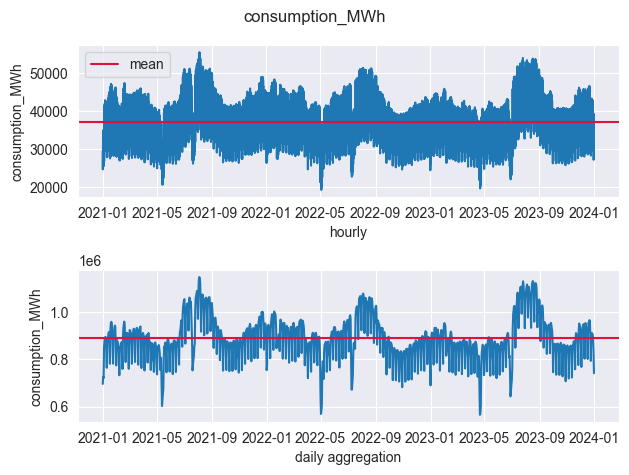

In [69]:
# Consumption
time_plot(variable = "consumption_MWh")

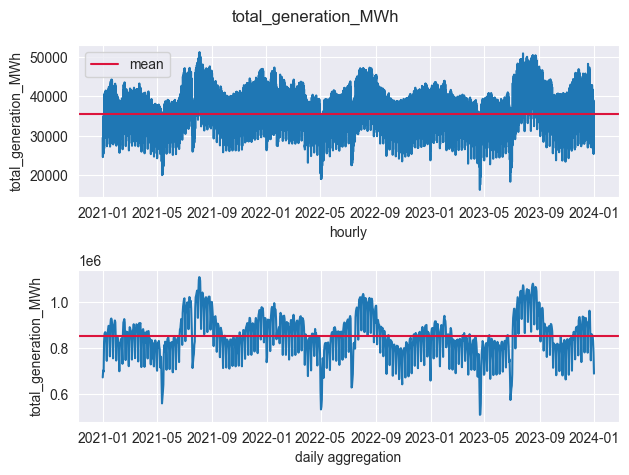

In [70]:
# Generation, total
time_plot(variable = "total_generation_MWh")

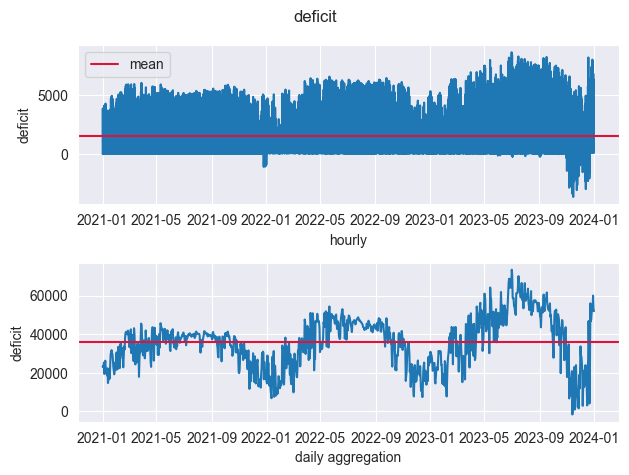

In [71]:
# Deficit
time_plot(variable = "deficit")

Consumption, generation & the deficits seems untrended overall.

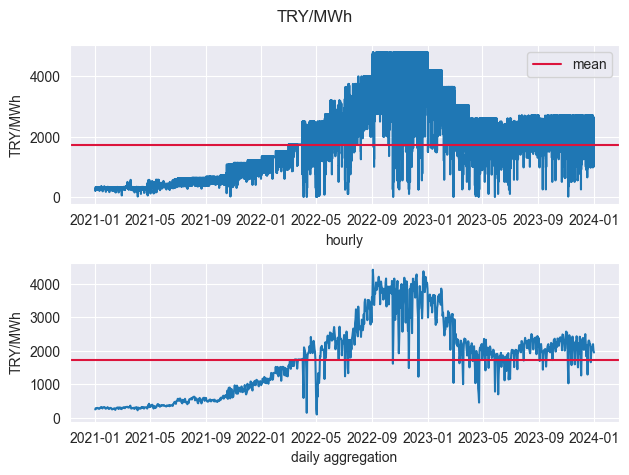

In [72]:
# Market clearing price, TRY
time_plot(variable = "TRY/MWh")

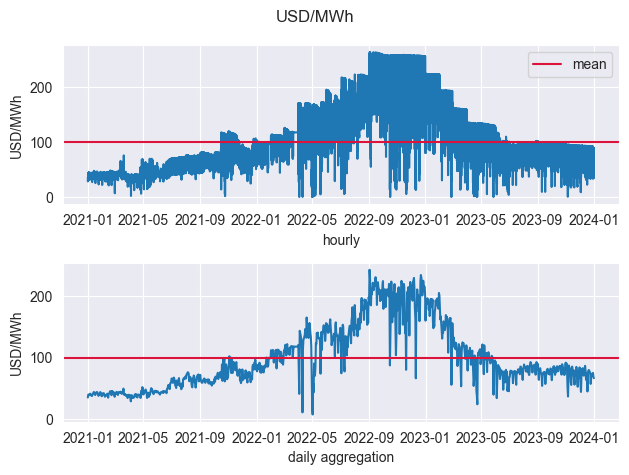

In [73]:
# Market clearing price, USD
time_plot(variable = "USD/MWh")

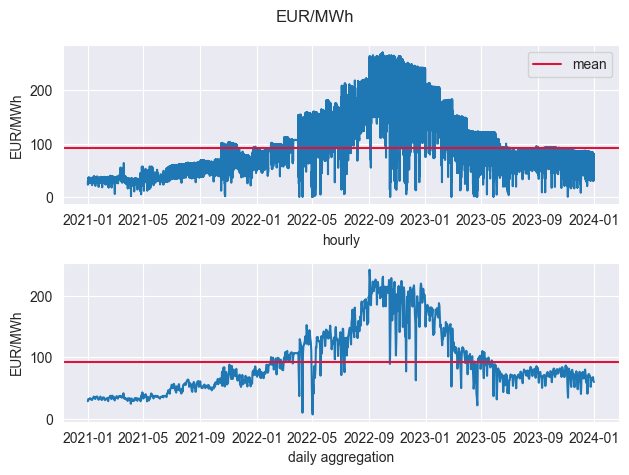

In [74]:
# Market clearing price, EUR
time_plot(variable = "EUR/MWh")

TRY is more volatile as expected. Use USD or EUR as target.

Russia - Ukraine war start: 2022-02-24. The increase in prices starts roughly in Summer 2021. Likely no long-term linear trend.

## Seasonal plots

In [180]:
def seasonal_plot1(df = df, variable = "consumption_MWh", groupby_year = True):

    # Grouping variable
    hue = None
    if groupby_year:
        hue = df.time.dt.year.astype(str)

    fig, ax = plt.subplots(2, 2)
    fig.suptitle("Seasonality, " + variable)

    # Hour of day
    _ = sns.lineplot(
        x = df.time.dt.hour,
        y = df[variable],
        hue = hue,
        marker = "o",
        markersize = 4,
        legend = False,
        ax = ax[0, 0]
    )
    _ = ax[0, 0].set_xticks(range(0, 25, 6))
    _ = ax[0, 0].set_xlabel("hour of day")

    # Day of week
    _ = sns.lineplot(
        x = df.time.dt.weekday,
        hue = hue,
        marker = "o",
        markersize = 4,
        legend = False,
        y = df[variable],
        ax = ax[0, 1]
    )
    _ = ax[0, 1].set_xticks(range(0, 7, 1))
    _ = ax[0, 1].set_xlabel("day of week, monday-sunday")

    # Week of year
    _ = sns.lineplot(
        x = df.time.dt.isocalendar().week,
        hue = hue,
        legend = False,
        y = df[variable],
        ax = ax[1, 0]
    )
    _ = ax[1, 0].set_xticks(range(0, 54, 8))
    _ = ax[1, 0].set_xlabel("week of year")

    # Month of year
    _ = sns.lineplot(
        x = df.time.dt.month,
        y = df[variable],
        hue = hue,
        marker = "o",
        markersize = 4,
        ax = ax[1, 1]
    )
    _ = ax[1, 1].set_xticks(range(1, 13, 1))
    _ = ax[1, 1].set_xlabel("month")

    if not groupby_year:
        return
    
    _ = ax[1, 1].legend(
            title = "year", 
            bbox_to_anchor = (1.05, 1.0), 
            fontsize = "small",
            loc = "best"
    )

In [181]:
def seasonal_plot2(df = df, variable = "consumption_MWh", groupby_month = True):

    # Grouping variable
    hue = None
    if groupby_month:
        hue = df.time.dt.month.astype(str)

    fig, ax = plt.subplots(2)
    fig.suptitle("Seasonality, " + variable)

    # Hour of day
    _ = sns.lineplot(
        x = df.time.dt.hour,
        y = df[variable],
        hue = hue,
        markers = hue,
        #marker = "o",
        markersize = 4,
        ax = ax[0]
    )
    _ = ax[0].set_xticks(range(0, 25, 6))
    _ = ax[0].set_xlabel("hour of day")

    # Day of week
    _ = sns.lineplot(
        x = df.time.dt.weekday,
        hue = hue,
        markers = hue,
        #marker = "o",
        markersize = 4,
        legend = False,
        y = df[variable],
        ax = ax[1]
    )
    _ = ax[1].set_xticks(range(0, 7, 1))
    _ = ax[1].set_xlabel("day of week, monday-sunday")

    if not groupby_month:
        return
    
    _ = ax[0].legend(
            title = "month", 
            bbox_to_anchor = (1.05, 1.0), 
            fontsize = "small",
            loc = "best"
    )

In [182]:
def seasonal_plot3(df = df, variable = "consumption_MWh"):

    hue = df.time.dt.month.astype(str)

    fig, ax = plt.subplots(2)
    fig.suptitle("Seasonality, " + variable)

    # Day of month, ungrouped
    _ = sns.lineplot(
        x = df.time.dt.day,
        y = df[variable],
        hue = None,
        marker = "o",
        markersize = 4,
        legend = False,
        ax = ax[0]
    )
    _ = ax[0].set_xticks(range(1, 32, 6))
    _ = ax[0].set_xlabel("day of month")

    # Day of month, grouped
    _ = sns.lineplot(
        x = df.time.dt.day,
        y = df[variable],
        hue = hue,
        ax = ax[1]
    )
    _ = ax[1].set_xticks(range(1, 32, 6))
    _ = ax[1].set_xlabel("day of month")

    _ = ax[1].legend(
            title = "month", 
            bbox_to_anchor = (1.05, 1.0), 
            fontsize = "small",
            loc = "best"
    )

### Consumption

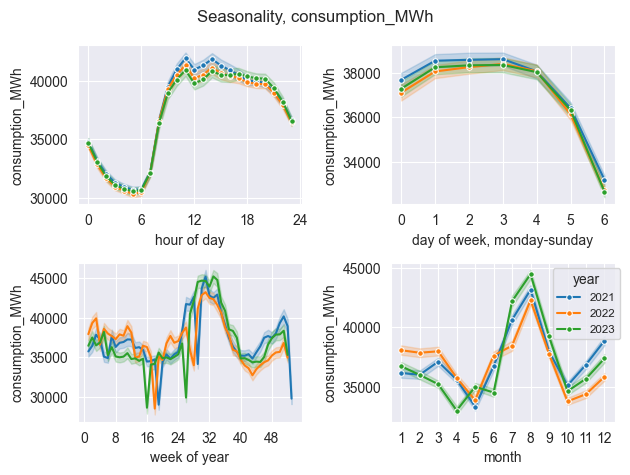

In [183]:
# Consumption seasonality, by year
seasonal_plot1(
    variable = "consumption_MWh",
    groupby_year = True
)

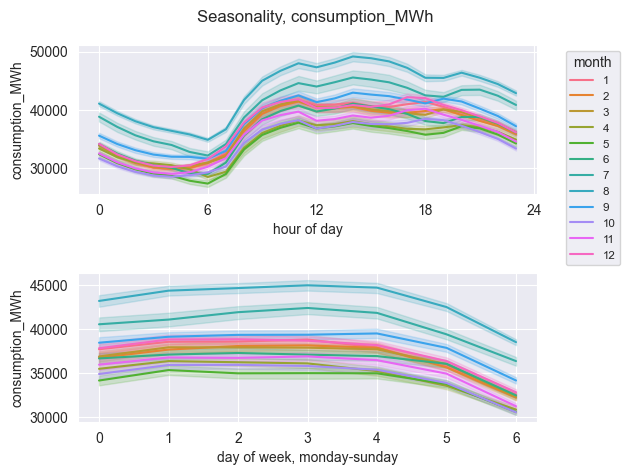

In [184]:
# Consumption seasonality, by month
seasonal_plot2(
    variable = "consumption_MWh",
    groupby_month = True
)

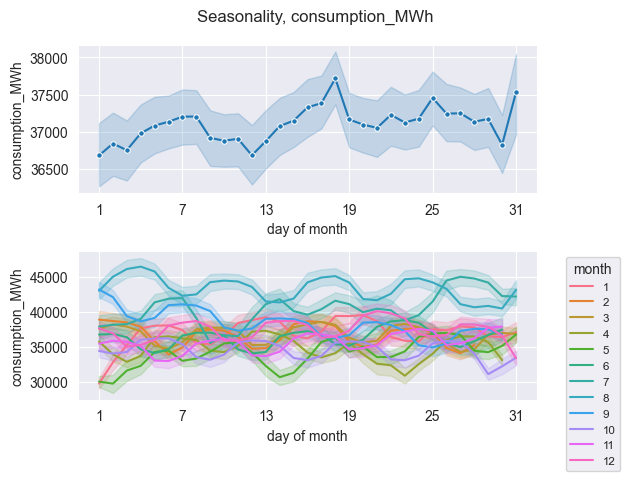

In [185]:
# Consumption day of month seasonality, by month
seasonal_plot3(variable = "consumption_MWh")

### Deficit

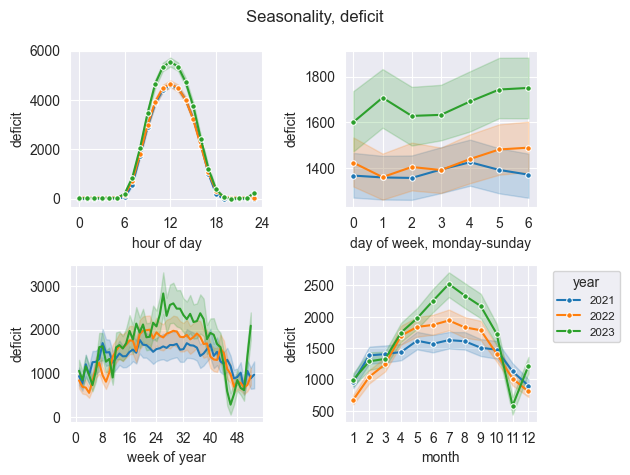

In [186]:
# Deficit seasonality, by year
seasonal_plot1(
    variable = "deficit",
    groupby_year = True
)

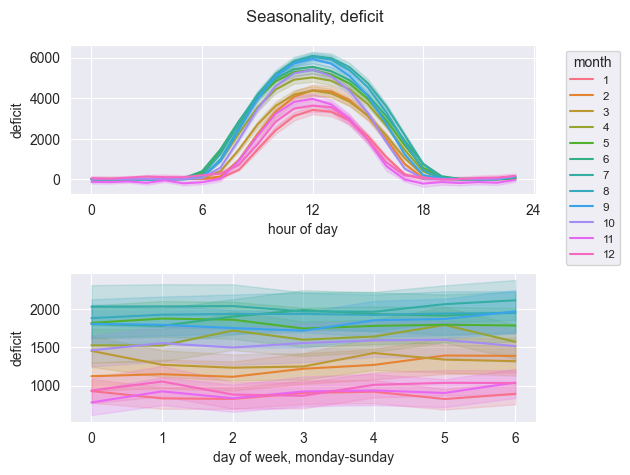

In [187]:
# Deficit seasonality, by month
seasonal_plot2(
    variable = "deficit",
    groupby_month = True
)

Deficits very dependably ramp from 6am to 12 am, decline to 18pm. Sometimes they happen around 12am. They ramp towards the summer and decline afterwards.

### Price USD

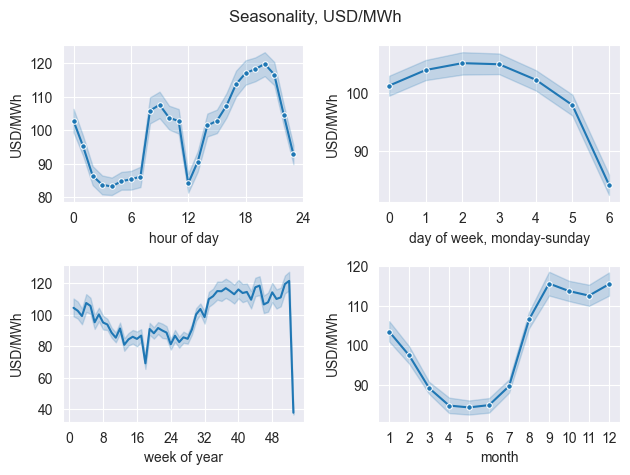

In [191]:
# Price seasonality
seasonal_plot1(
    variable = "USD/MWh",
    groupby_year = False
)

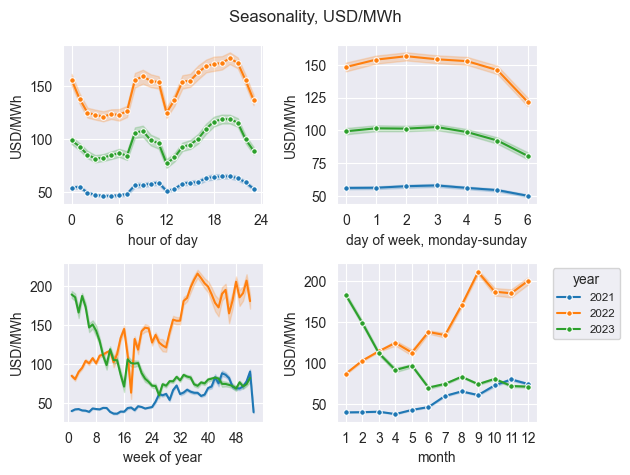

In [192]:
# Price seasonality, by year
seasonal_plot1(
    variable = "USD/MWh",
    groupby_year = True
)

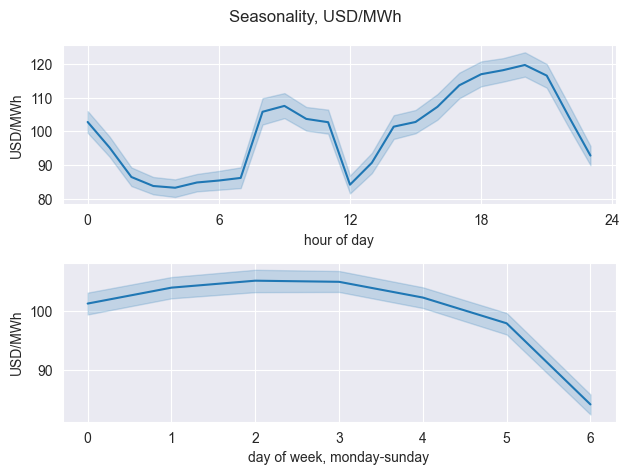

In [193]:
# Price seasonality
seasonal_plot2(
    variable = "USD/MWh",
    groupby_month = False
)

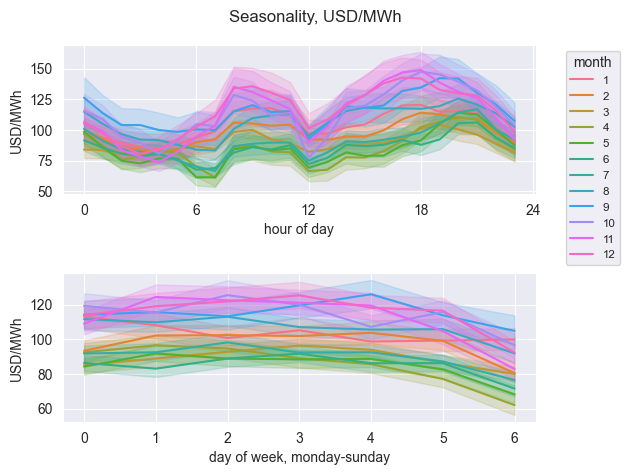

In [190]:
# Price seasonality, by month
seasonal_plot2(
    variable = "USD/MWh",
    groupby_month = True
)

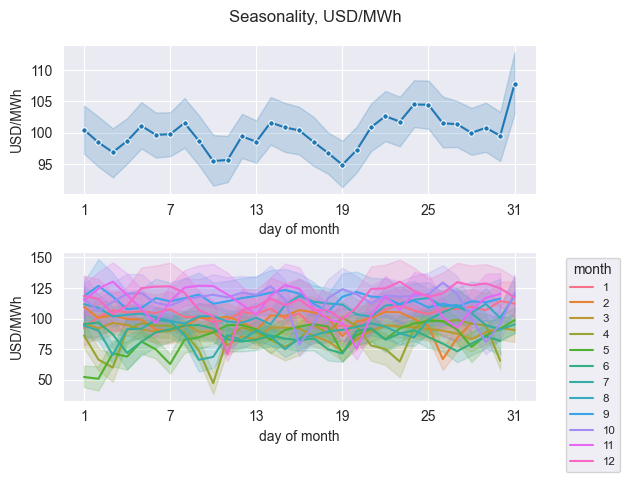

In [194]:
# Price day of month seasonality, by month
seasonal_plot3(variable = "USD/MWh")

Seasonality features to use: Day of hour, day of week, month.

## Autocorrelation plots